# Construção do Treinamento de MaskRCNN
- **Classe cfgDataset**: Consome e ordena os arquivos do dataset

In [17]:
from os import listdir
import numpy as np
from mrcnn.utils import Dataset
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import skimage.io

class cfgDataset(object):
    @staticmethod
    def process(path):
        #global_path = '/home/lsanche/Documentos/uva/data/img'
        global_path = path
        txt_list_paths = list(Path(global_path).glob("*.txt"))
        npz_list_paths = list(Path(global_path).glob("*.npz"))
        jpg_list_paths = list(Path(global_path).glob("*.jpg"))

        bag_ordered_txt = []
        bag_ordered_npz = []
        for jpg in range(len(jpg_list_paths)):
            a = str(jpg_list_paths[jpg]).split('/')[-1].split('.')[0]
            for txt in range(len(txt_list_paths)):
                b = str(txt_list_paths[txt]).split('/')[-1].split('.')[0]
                if a == b:
                    bag_ordered_txt.append(txt)

            for npz in range(len(npz_list_paths)):
                c = str(npz_list_paths[npz]).split('/')[-1].split('.')[0]
                if a == c:
                    bag_ordered_npz.append(npz)
        jpg_ordered_list = [str(jpg_list_paths[i]) for i in range(len(jpg_list_paths))]
        txt_ordered_list = [str(txt_list_paths[i]) for i in bag_ordered_txt]
        npz_ordered_list = [str(npz_list_paths[i]) for i in bag_ordered_npz]
        return jpg_ordered_list, txt_ordered_list, npz_ordered_list
cfg = cfgDataset()
imgs_data, txt_data, npz_data = cfg.process('/home/lsanche/Documentos/uva/data/img')


# Implementação do Dataset no mrcnn
- Para realizar a implementação, temos que herdar a classe de dataset e add as imagens e os BB.

- **get_bb**: Método de consumo dos arquivos txt. Retorna a lista de bounding box

- **Class DatasetUva(Dataset)**: Implementação na classe Dataset do mrcnn
    - Os nomes dos métodos tem que ser idênticos à classe Dataset do mrcnn, pois como está herdando a classe, ela atua diretamente nas funções.
    - **load_dataset**: Add as imagens, paths e as BB
    - **extract_boxes**: transforma as coordenadas do BB para serem consumidas.
    - **load_mask**: Retorna as BB em forma de máscara

In [18]:
def get_bb(txt_path):
    bag = []
    with open(txt_path) as f:
        lines = f.readlines()
        for line in lines:
            b = line.split(' ')[1:]
            b = [float(i) for i in b]
            bag.append(b)
    return bag
class DatasetUva(Dataset):
    def load_dataset(self, img_list, txt_list, train_len:int=170, training:bool=True):
        
        self.add_class('dataset', 1, 'uva')
        imgs_train = img_list[:train_len]
        imgs_id_train = [str(imgs_train[i]).split('/')[-1].split('.')[0] for i in range(len(imgs_train))]
        #print(imgs_id_train)
        txt_train = txt_list[:train_len]
        
        imgs_test = img_list[train_len:]
        imgs_id_test = [str(imgs_test[i]).split('/')[-1].split('.')[0] for i in range(len(imgs_test))]
        #print(imgs_id_test)
        txt_test = txt_list[train_len:]
        
        if training:
            for i in range(len(imgs_train)):
                self.add_image('dataset', image_id=imgs_id_train[i], path=imgs_train[i], annotation=txt_train[i])
        else:
            for i in range(len(imgs_test)):
                self.add_image('dataset', image_id=imgs_id_train[i], path=imgs_train[i], annotation=txt_train[i])
    
    def extract_boxes(self, img_path):
        print(img_path)
        txt_path = img_path.split('.')[0] + '.txt'
        bb = get_bb(txt_path)
        img = skimage.io.imread(img_path)
        x_ = img.shape[1]
        y_ = img.shape[0]
        boxes = []
        for box in range(len(bb)):
            xmin = int((bb[box][0]*x_) - (bb[box][2]* x_)/2)
            ymin = int((bb[box][1]*y_) - (bb[box][3] * y_)/2)
            xmax = int((bb[box][0]*x_) + (bb[box][2] * x_)/2)
            ymax = int((bb[box][1]*y_) + (bb[box][3]*y_)/2)
            coord = [xmin, ymin, xmax, ymax]
            boxes.append(coord)
        return boxes, x_, y_
    
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['path']
        boxes, w ,h = self.extract_boxes(path)
        masks = np.zeros([h,w,len(boxes)], dtype='uint8')
        class_ids = []
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e] = 1
            class_ids.append(self.class_names.index('uva'))
        return masks, np.asarray(class_ids, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# Prepara o dataset
 - Aqui é realizado o processamento do dataset que será consumido para treinamento e teste.

In [19]:
train_set = DatasetUva()
train_set.load_dataset(imgs_data, txt_data, training=True)
train_set.prepare()
#train_set.extract_bb(imgs_data[0], txt_data[0])


test_set = DatasetUva()
test_set.load_dataset(imgs_data, txt_data, training=False)
test_set.prepare()

# Verificando Dataset
- Análise visual das imagens e seus respectivos BB

(1365, 2048, 3)
/home/lsanche/Documentos/uva/data/img/CSV_1877.jpg
(1365, 2048, 10)


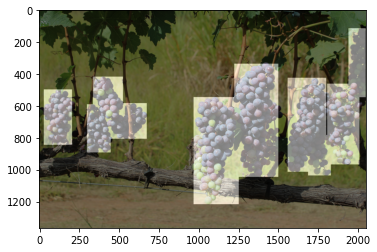

(1365, 2048, 3)
/home/lsanche/Documentos/uva/data/img/CDY_2034.jpg
(1365, 2048, 13)


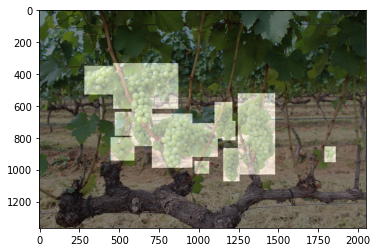

(1365, 2048, 3)
/home/lsanche/Documentos/uva/data/img/SVB_1973.jpg
(1365, 2048, 20)


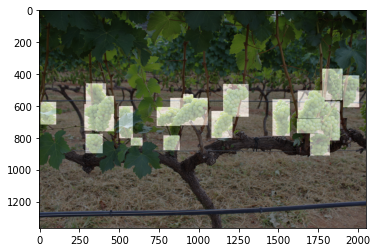

(1365, 2048, 3)
/home/lsanche/Documentos/uva/data/img/CDY_2027.jpg
(1365, 2048, 8)


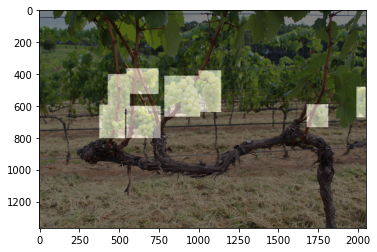

(1365, 2048, 3)
/home/lsanche/Documentos/uva/data/img/CSV_1903.jpg
(1365, 2048, 9)


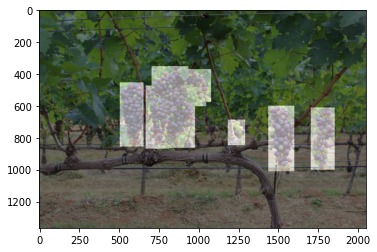

In [20]:
for i in range(5):


    image_id = i
    image = train_set.load_image(image_id)
    print(image.shape)
    mask, class_ids = train_set.load_mask(image_id)
    print(mask.shape)
    plt.imshow(image)
    plt.imshow(mask[:,:,0], cmap='gray', alpha=0.5)
    plt.show()

# Display_Instances

- Análise visual das imagens com processamento via mrcnn

{'id': 'CSV_1877', 'source': 'dataset', 'path': '/home/lsanche/Documentos/uva/data/img/CSV_1877.jpg', 'annotation': '/home/lsanche/Documentos/uva/data/img/CSV_1877.txt'}
/home/lsanche/Documentos/uva/data/img/SVB_1973.jpg


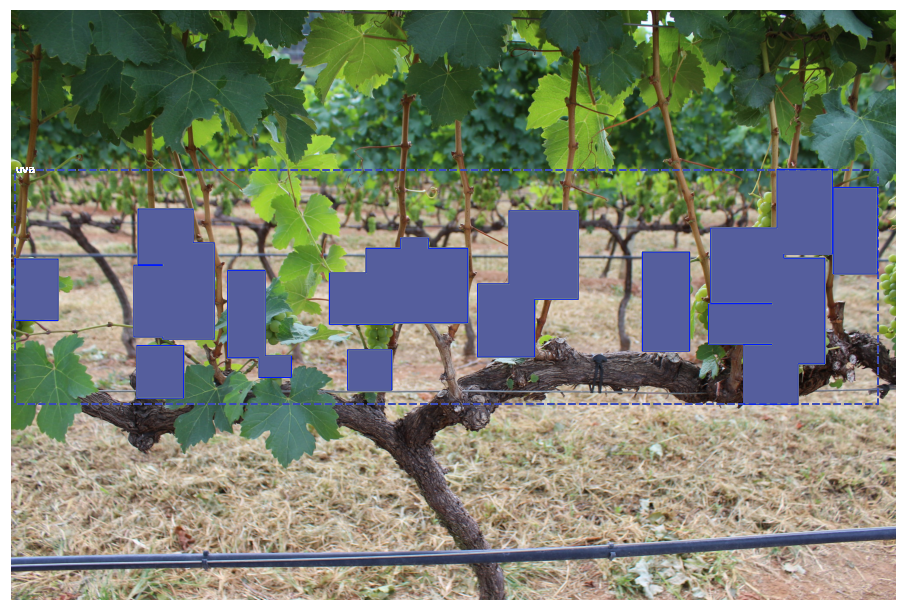

In [21]:
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
for image_id in train_set.image_ids:
    info = train_set.image_info[image_id]
    print(info)
    break
image_id = 2
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, train_set.class_names)

# Configuração do modelo

- Configuração dos parâmetros de treinamento.
    - **NUM_CLASSES**: 2, sendo uma referênte ao background e outra ao cacho de uva.
    - **STEPS_PER_EPOCH**: está como 1 devido ao grande consumo do modelo, aumentar caso queira realizar o treinamento 

In [22]:
import mrcnn
import mrcnn.utils
import mrcnn.config
import mrcnn.model
from mrcnn import visualize
from mrcnn.model import log
class UvaConfig(mrcnn.config.Config):
    NAME ='uva_cfg'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2
    LEARNING_RATE = 0.001
    STEPS_PER_EPOCH = 1

uva_config = UvaConfig()
uva_config.display()
UseAllowGrowth = True
UseGPUnum = "0"


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# Modelo

In [23]:
model = mrcnn.model.MaskRCNN(mode = 'training', model_dir = './log', config=uva_config)
#model.keras_model.summary()
#model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# Modelo pré-treinado
- carrega modelo de pré-treinamento com os dados do COCO


In [24]:

#model.load_weights(filepath='/home/lsanche/Documentos/uva/model/mask_rcnn_coco.h5',by_name=True,exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])
model.load_weights('/home/lsanche/Documentos/uva/model/mask_rcnn_cocov2.h5',by_name=True ,exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
#uva_config.display()

## Sumário da arquitetura MRCNN

In [14]:
#model.keras_model.summary()

# Treinamento
- **epochs**: Número de épocas do treinamento
- **Layers**: Camadas que serão treinadas

In [ ]:
model.train(train_set, test_set, learning_rate=uva_config.LEARNING_RATE, epochs=1, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./log/uva_cfg20210710T1926/mask_rcnn_uva_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeD

/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packag

Epoch 1/1
/home/lsanche/Documentos/uva/data/img/CSV_1907.jpg/home/lsanche/Documentos/uva/data/img/CSV_1907.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1907.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1907.jpg/home/lsanche/Documentos/uva/data/img/CSV_1907.jpg/home/lsanche/Documentos/uva/data/img/CSV_1907.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1907.jpg/home/lsanche/Documentos/uva/data/img/CSV_1907.jpg

Epoch 1/1
/home/lsanche/Documentos/uva/data/img/CSV_1907.jpg


/home/lsanche/Documentos/uva/data/img/CSV_1907.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1907.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1907.jpg

/home/lsanche/Documentos/uva/data/img/SYH_2017-04-27_1338.jpg
/home/lsanche/Documentos/uva/data/img/SYH_2017-04-27_1338.jpg/home/lsanche/Documentos/uva/data/img/SYH_2017-04-27_1338.jpg
/home/lsanche/Documentos/uva/data/img/SYH_2017-04-27_1338.jpg
/home/lsanche/Documentos/uva/data/img/SYH_2017-04-27_1338.jpg

/home/lsanche/Documentos/uva/data/img/SYH_2017-04-27_1338.

/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  
/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  
/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be 

/home/lsanche/Documentos/uva/data/img/CSV_1893.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1869.jpg

/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  


/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  
/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  
/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be 

/home/lsanche/Documentos/uva/data/img/CSV_1893.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1869.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1869.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1893.jpg


/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  


/home/lsanche/Documentos/uva/data/img/CSV_1869.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1893.jpg


/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  


/home/lsanche/Documentos/uva/data/img/CSV_1893.jpg

/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  



/home/lsanche/Documentos/uva/data/img/CSV_1893.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1893.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1893.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1893.jpg/home/lsanche/Documentos/uva/data/img/CSV_1893.jpg

/home/lsanche/Documentos/uva/data/img/CSV_1869.jpg

/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  



/home/lsanche/Documentos/uva/data/img/CSV_1869.jpg


/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  


/home/lsanche/Documentos/uva/data/img/CSV_1869.jpg


/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  


/home/lsanche/Documentos/uva/data/img/CSV_1893.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1869.jpg/home/lsanche/Documentos/uva/data/img/CSV_1893.jpg



/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  


/home/lsanche/Documentos/uva/data/img/CSV_1869.jpg/home/lsanche/Documentos/uva/data/img/CSV_1869.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1869.jpg

/home/lsanche/Documentos/uva/data/img/CSV_1869.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1877.jpg


/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  
/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  
/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be 

/home/lsanche/Documentos/uva/data/img/CSV_1877.jpg/home/lsanche/Documentos/uva/data/img/CSV_1909.jpg


/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  


/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  
/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  


/home/lsanche/Documentos/uva/data/img/CSV_1909.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1909.jpg


/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  
/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  
/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be 

/home/lsanche/Documentos/uva/data/img/CSV_1909.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1877.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1909.jpg


/home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  
